In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import pickle
from pymoo.indicators.hv import HV
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.problems import get_problem as get_prob_pymoo
from problem import get_problem

In [2]:
def front_truth(problem_name):
    if problem_name == "DTLZ2":
        # ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=30)
        # return get_prob_pymoo("dtlz2").pareto_front(ref_dirs)
        n_sample = 50
        r = 1
        u = np.linspace(0, np.pi/2, n_sample)
        v = np.linspace(0, np.pi/2, n_sample)
        a = np.expand_dims(r*np.outer(np.cos(u), np.sin(v)).flatten(), axis=1)
        b = np.expand_dims(r*np.outer(np.sin(u), np.sin(v)).flatten(), axis=1)
        c = np.expand_dims(r*np.outer(np.ones(np.size(u)), np.cos(v)).flatten(), axis=1)
        return np.hstack((a,b,c))
    elif problem_name == "cybenko_shifted":
        problem = get_problem(problem_name)
        x = np.linspace(1, 3, 100)
        x = torch.from_numpy(x).unsqueeze(1)
        return problem.evaluate(x).numpy()
    else:
        problem = get_problem(problem_name)
        x = np.linspace(-1, 1, 400)
        x = torch.from_numpy(x).unsqueeze(1)
        return problem.evaluate(x).numpy()

In [3]:
def plot_compare_evaluation(problem_name = "DTLZ2", n_dim = 5, n_warm_eval=120):
    log_dir = f"logs_{problem_name}"
    Y_evaluation_original = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_original.npy') 
    Y_evaluation_EHVI = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_warmup_init_EHVI_{n_warm_eval}.npy')
    Y_evaluation_DGEMO = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_warmup_init_DGEMO_{n_warm_eval}.npy')
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = front_truth(problem_name)
    max_HV = hv(truth_pareto)
    

    hv_original, hv_EHVI, hv_DGEMO = [], [], []
    for i in range(Y_evaluation_original.shape[0]):
        hv_original.append(hv(Y_evaluation_original[:i]))
        
    for i in range(Y_evaluation_EHVI.shape[0]):
        hv_EHVI.append(hv(Y_evaluation_EHVI[:i]))
        hv_DGEMO.append(hv(Y_evaluation_DGEMO[:i]))
        
    if n_warm_eval == 120:
        n_train_eval = 50 * 5
    elif n_warm_eval == 220:
        n_train_eval = 50 * 5
        
    
    plt.plot(np.log(np.clip(max_HV - hv_original, a_min=1e-14, a_max=max_HV)), color='purple', linewidth=1, label=f"Original PSL, total {Y_evaluation_original.shape[0]} evaluations")
    plt.plot(np.log(np.clip(max_HV - hv_EHVI, a_min=1e-14, a_max=max_HV)), color='blue', linewidth=1, label=f"2-stage PSL with EHVI, total {Y_evaluation_EHVI.shape[0]} evaluations")
    plt.plot(np.log(np.clip(max_HV - hv_DGEMO, a_min=1e-14, a_max=max_HV)), color='green', linewidth=1, label=f"2-stage PSL with DGEMO, total {Y_evaluation_EHVI.shape[0]} evaluations")
    
    plt.axvline(x = n_warm_eval, color = 'black', linestyle='dashed', linewidth = 1, label=f"Warmup milestone")
    
    plt.ylabel("Log Hypervolume difference")
    plt.xlabel("Evaluation")
    plt.title(f"Log Hypervolume difference {problem_name} - N dim: {n_dim} \nOriginal PSL: Training evaluation: {20+50*10}\n2 Stage: Warmup evaluations: {n_warm_eval}, Training evaluations: {n_train_eval}",fontweight="bold")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.45))
    plt.show()

In [4]:
def plot_compare_ablation(problem_name = "DTLZ2", n_dim = 5):
    log_dir = f"logs_{problem_name}_ablation"
    Y_evaluation_original = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_original.npy') 
    Y_evaluation_init = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_init_uniform.npy')
    Y_evaluation_warmup = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_warmup.npy')
    Y_evaluation_2stage = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_warmup_init_DGEMO_220_uniform.npy')
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = front_truth(problem_name)
    max_HV = hv(truth_pareto)
    

    hv_original, hv_init, hv_warmup, hv_2stage = [], [], [], []
    for i in range(Y_evaluation_original.shape[0]):
        hv_original.append(hv(Y_evaluation_original[:i]))
        hv_init.append(hv(Y_evaluation_init[:i]))
        
    for i in range(Y_evaluation_2stage.shape[0]):
        hv_warmup.append(hv(Y_evaluation_warmup[:i]))
        hv_2stage.append(hv(Y_evaluation_2stage[:i]))
        
    n_train_eval = 50 * 5
        
    
    plt.plot(np.log(np.clip(max_HV - hv_original, a_min=1e-14, a_max=max_HV)), color='black', linewidth=1, label=f"PSL-MOBO")
    plt.plot(np.log(np.clip(max_HV - hv_init, a_min=1e-14, a_max=max_HV)), color='green', linewidth=1, label=r"MOBO-PSL with $\theta$ initialization")
    plt.plot(np.log(np.clip(max_HV - hv_warmup, a_min=1e-14, a_max=max_HV)), color='orange', linewidth=1, label=f"MOBO-PSL with DGEMO warm up")
    plt.plot(np.log(np.clip(max_HV - hv_2stage, a_min=1e-14, a_max=max_HV)), color='purple', linewidth=1, label=f"Co-PSL")
    
    plt.axvline(x = 220, color = 'black', linestyle='dashed', linewidth = 1, label=f"Warmup 220 evaluations")
    
    plt.ylabel("Log Hypervolume difference")
    plt.xlabel("Number of evaluation")
    plt.title(f"Log Hypervolume difference between the learned Pareto \n front and truth Pareto Front after total 470 evaluations")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.45), ncols=2)
    plt.savefig(f"LHD_ablation_{problem_name}.pdf", bbox_inches='tight')
    plt.show()

In [5]:
def plot_compare_ablation_init(problem_name = "DTLZ2", n_dim = 5):
    log_dir = f"logs_{problem_name}"
    Y_evaluation_init_uniform = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_init_uniform.npy')
    Y_evaluation_2stage_uniform = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_warmup_init_DGEMO_220_uniform.npy')
    Y_evaluation_init_gaussian = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_init_gaussian.npy')
    Y_evaluation_2stage_gaussian = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_warmup_init_DGEMO_220_gaussian.npy')
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = front_truth(problem_name)
    max_HV = hv(truth_pareto)
    

    hv_init_gaussian, hv_init_uniform, hv_2stage_gaussian, hv_2stage_uniform = [], [], [], []
    for i in range(Y_evaluation_init_uniform.shape[0]):
        hv_init_uniform.append(hv(Y_evaluation_init_uniform[:i]))
        hv_init_gaussian.append(hv(Y_evaluation_init_gaussian[:i]))
        
    for i in range(Y_evaluation_2stage_gaussian.shape[0]):
        hv_2stage_gaussian.append(hv(Y_evaluation_2stage_gaussian[:i]))
        hv_2stage_uniform.append(hv(Y_evaluation_2stage_uniform[:i]))
        
    n_train_eval = 50 * 5
        
    
    plt.plot(np.log(np.clip(max_HV - hv_init_gaussian, a_min=1e-14, a_max=max_HV)), color='black', linewidth=1, label=f"PSL with theta initialization, total {Y_evaluation_init_uniform.shape[0]} evaluations (Gaussian)")
    plt.plot(np.log(np.clip(max_HV - hv_init_uniform, a_min=1e-14, a_max=max_HV)), color='purple', linewidth=1, label=f"PSL with theta initialization, total {Y_evaluation_init_uniform.shape[0]} evaluations (Uniform)")
    plt.plot(np.log(np.clip(max_HV - hv_2stage_uniform, a_min=1e-14, a_max=max_HV)), color='blue', linewidth=1, label=f"2-stage PSL with DGEMO warmup, total {Y_evaluation_2stage_gaussian.shape[0]} evaluations (Uniform)")
    plt.plot(np.log(np.clip(max_HV - hv_2stage_gaussian, a_min=1e-14, a_max=max_HV)), color='green', linewidth=1, label=f"2-stage PSL with DGEMO warmup, total {Y_evaluation_2stage_gaussian.shape[0]} evaluations (Gaussian)")
    
    plt.axvline(x = 220, color = 'black', linestyle='dashed', linewidth = 1, label=f"Warmup milestone")
    
    plt.ylabel("Log Hypervolume difference")
    plt.xlabel("Number of evaluation")
    plt.title(f"Log Hypervolume difference {problem_name} - N dim: {n_dim}\nWarmup evaluations: 220\nTraining evaluations: {n_train_eval}")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.55), ncols=2)
    plt.show()

### DTLZ2

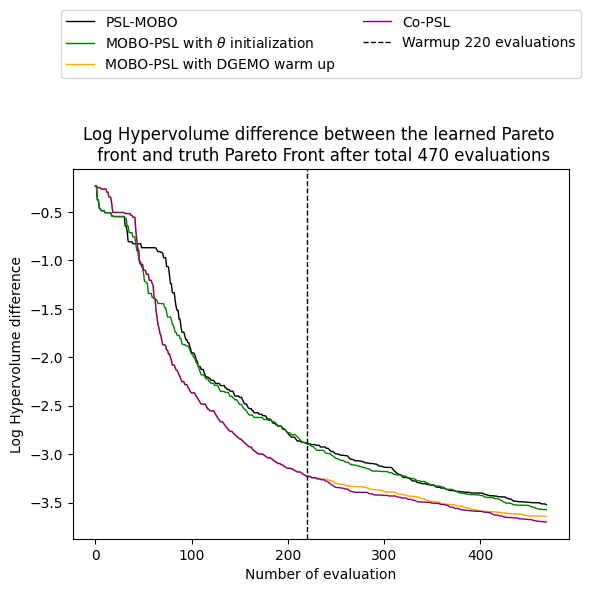

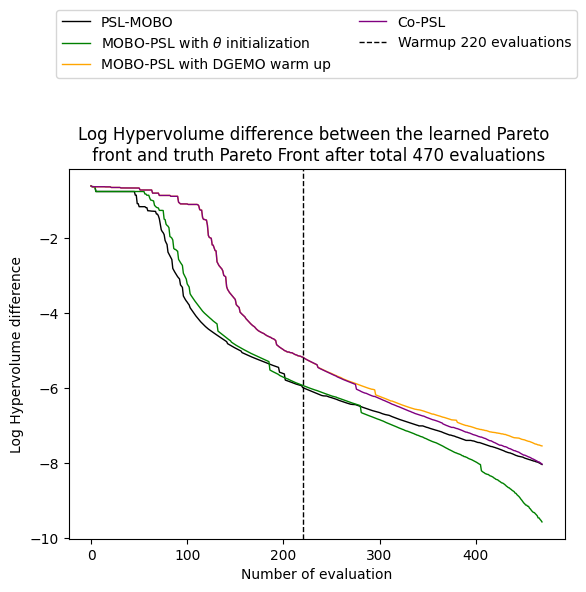

In [6]:
problem_name = "DTLZ2"
plot_compare_ablation(problem_name, n_dim = 6)
# plot_compare_ablation_init(problem_name, n_dim = 6)

problem_name = "VLMOP2"
plot_compare_ablation(problem_name, n_dim = 4)